# Import and misc

In [1]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt
import random


# Task

In [2]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

### Creating MelSpecs on GPU for speeeed: 

In [3]:
class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

# Streaming

In [4]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output


In [5]:
class StreamCRNN(nn.Module):
    def __init__(self, config, max_window_length=100, streaming_step_size=5):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)

        self.max_window_length = max_window_length
        self.streaming_step_size = streaming_step_size

        self.melspec = LogMelspec(is_train=False, config=TaskConfig)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output


    def stream_forward(self, input, hidden=None):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, hidden = self.gru(conv_output, hidden) if hidden is not None else self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output, hidden

    def stream(self, input):
        self.eval()
        input = input.sum(dim=0)
        input = self.melspec(input.unsqueeze(0).to(sconfig.device))
        kernel_width = self.conv[0].kernel_size[1]
        stride = self.conv[0].stride[-1]
        max_window_length = self.max_window_length - (self.max_window_length - kernel_width) % stride
        hidden = None
        
        output, hidden = self.stream_forward(input[:,:,:max_window_length])
        result = output.unsqueeze(1)

        for i in range(max_window_length, input.shape[-1], self.streaming_step_size):
            output, hidden = self.stream_forward(input[:,:, i - max_window_length + 1 : i + 1], hidden=hidden)
            output = output.unsqueeze(1)
            result = torch.cat((result, output[:, -1:]), dim=1)
        probs = F.softmax(result, dim=-1)[0].detach().numpy()
        clear_output()
        plt.plot(list(range(self.max_window_length // 2, probs.shape[0] * self.streaming_step_size + self.max_window_length // 2, self.streaming_step_size)), probs[:,1])
        return result
   

In [6]:
@dataclasses.dataclass
class StudentConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 1e-3 # 3e-4
    weight_decay: float = 1e-5 # 1e-5
    num_epochs: int = 40 # 20
    n_mels: int = 40
    cnn_out_channels: int = 2 # 8
    kernel_size: Tuple[int, int] = (5, 20) # (5, 20)
    stride: Tuple[int, int] = (2, 8) # (2, 8)
    hidden_size: int = 22 # 64
    gru_num_layers: int = 1 # 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')
    T: float = 10
    a: float = 0.6

In [7]:
sconfig = StudentConfig()
model = torch.load("student_model.pth", map_location=torch.device('cpu')).eval()
torch.save(model.state_dict(), 'student_model.pt')

model = StreamCRNN(sconfig)
model.load_state_dict(torch.load('student_model.pt', map_location='cpu'))
model.eval()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


StreamCRNN(
  (conv): Sequential(
    (0): Conv2d(1, 2, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(36, 22, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=22, out_features=22, bias=True)
      (1): Tanh()
      (2): Linear(in_features=22, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=22, out_features=2, bias=True)
)

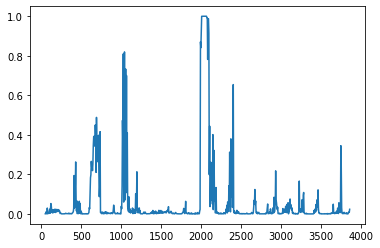

In [8]:
# в audio соединены 40 секундных записей, посередине - с ключевым словом

wav, sr = torchaudio.load('audio.wav')
result = model.stream(wav)